In [212]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import torchvision 
import random
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset, Subset
from PIL import Image
from sklearn.model_selection import train_test_split

In [213]:
dataset_dir = '/home/shihas/Documents/project_1/data'

if not os.path.exists(dataset_dir):
    print(f"dataset {dataset_dir} not found")

class1_path = ['01 No DR', '02 Mild NPDR']
class0_path = ['03 Moderate NPDR', '04 Severe NPDR', '05 PDR', 
                '06 Mild NPDR, with DME', '07 Moderate NPDR, with DME',
                '08 Severe NPDR, with DME', '09 PDR, with DME']


In [214]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Augmentation for class 0
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

class DRDataset(Dataset):
    def __init__(self,root_dir,transform=None, augment_factor=5):
        self.root_dir = root_dir
        self.transform = transform
        self.augment_factor = augment_factor
        self.image_paths = []
        self.labels = []

        class0_images = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            
            if not os.path.isdir(folder_path):
                continue

            label = 1 if folder in class1_path else 0 if folder in class0_path else None
        

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_path.lower().endswith(('.png','.jpg','jpeg')):
                    if label ==0:
                        class0_images.append(img_path)
                    else:
                        self.image_paths.append(img_path)
                        self.labels.append(label)
        for img_path in class0_images:
            for _ in range(self.augment_factor):  # Create multiple copies
                self.image_paths.append(img_path)
                self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label= self.labels[idx]
        
        if label == 0 and random.random() < 0.8:
            image = augment_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image,label

dataset = DRDataset(dataset_dir, transform=transform, augment_factor = 5)
print(f"Total Images: {len(dataset)}")
class_counts = np.bincount(np.array(dataset.labels))
print(f"Class Counts: {class_counts}")

Total Images: 7242
Class Counts: [3515 3727]


Text(0.5, 1.0, 'class distribution')

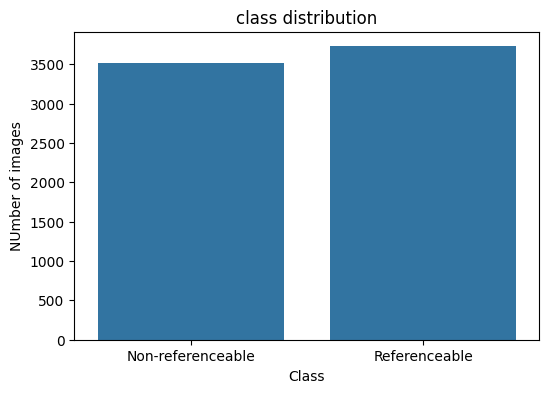

In [215]:
class_names = ['Non-referenceable', 'Referenceable']
plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=class_counts)
plt.xlabel('Class')
plt.ylabel('NUmber of images')
plt.title('class distribution')

<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


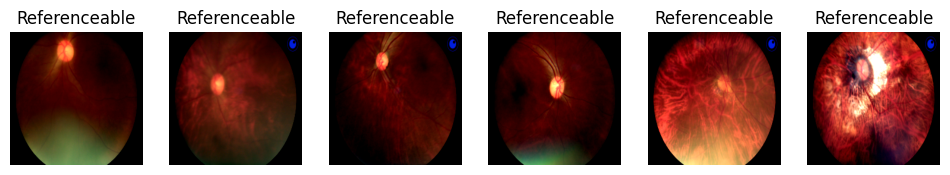

In [216]:
def show_sample_images(dataset, num_images=6):
    fig,axes = plt.subplots(1,num_images, figsize=(12,4))

    for i in range(num_images):
        img,label = dataset[i]
        img = img.permute(1,2,0).numpy()
        img = img * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

plt.tight_layout()
plt.show()

show_sample_images(dataset)

In [220]:
indices = list(range(len(dataset)))
train_indices,test_indices = train_test_split(indices,test_size=0.2,stratify=dataset.labels,random_state=42)

train_dataset = Subset(dataset,train_indices)
test_dataset = Subset(dataset, test_indices)

train_loder = DataLoader(train_dataset,batch_size=32, shuffle=True)
test_loder = DataLoader(test_dataset,batch_size=32, shuffle=True)

print(f"Training Set: {len(train_dataset)} images")
print(f"Testing Set: {len(test_dataset)} images")


Training Set: 5793 images
Testing Set: 1449 images
